In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from numpy.linalg import matrix_power
from numpy.random import choice

from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime, timedelta
from decimal import *

import mdptoolbox

# Load Scottish Data

In [3]:
df_metocean = pd.read_csv("Scotland_metocean_removed.csv")
df_metocean

,Year,Month,Day,Hour,Hs (m),v10 (m/s)
0,2008,1,1,0,3.446098,6.504866
1,2008,1,1,6,3.337338,7.705570
2,2008,1,1,12,3.195431,7.402196
3,2008,1,1,18,2.971436,6.317548
4,2008,1,2,0,3.067249,7.646887
...,...,...,...,...,...,...
14595,2017,12,30,18,4.619158,10.236058
14596,2017,12,31,0,4.509621,7.472284
14597,2017,12,31,6,3.979025,6.199845
14598,2017,12,31,12,3.666209,11.561856


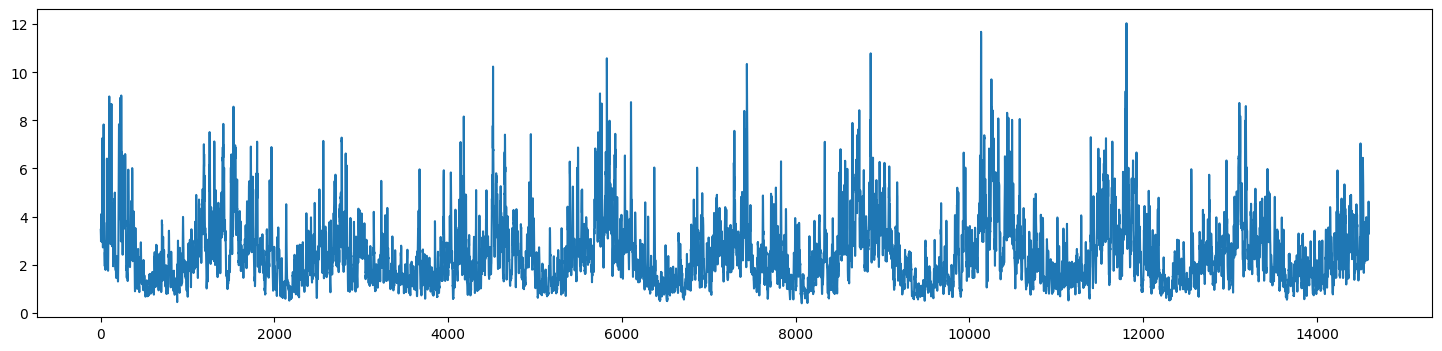

In [4]:
fig, ax = plt.subplots(1, figsize=(18,4))
ax.plot(df_metocean['Hs (m)'])
plt.show()

In [5]:
OperationalCriteria = 2 #significant wave height

In [6]:
#Elapsed time series
BinaryTS = df_metocean['Hs (m)'] <= OperationalCriteria
BinaryTS = BinaryTS.astype(int)
ElapsedFavorableTime = np.zeros_like(BinaryTS)
if BinaryTS[0]:
    ElapsedFavorableTime[0] = 1
for i in range(1,BinaryTS.shape[0]):
    if BinaryTS[i]:
        ElapsedFavorableTime[i] = ElapsedFavorableTime[i-1] + 1

#burnin
burnin = np.where(ElapsedFavorableTime == 0)[0][0]
BinaryTS = np.array(BinaryTS[burnin:])
elaps = ElapsedFavorableTime[burnin:]
ub = np.max(elaps)

# MDP solver

In [7]:
def MDPsolver(elaps, wmax, dmax, n = 4, t_aux = 0, c_down = -1.5, c_fail = -1, discount = 0.95):
    #Intermediate transition matrix
    CmfWTC = np.zeros(shape=(wmax+1,wmax+1), dtype=int)
    CmfWTC_n = np.zeros(shape=(wmax+1,wmax+1), dtype=int)
    
    for i in range(1,len(elaps)):
        if (elaps[i-1] <= wmax) & (elaps[i] <= wmax):
            CmfWTC[elaps[i-1],elaps[i]] += 1
        elif (elaps[i-1] == wmax) & (elaps[i] == wmax+1):
            CmfWTC[elaps[i-1],elaps[i-1]] += 1
    for i in range(n,len(elaps)):
        if (elaps[i-n] <= wmax) & (elaps[i] <= wmax):
            CmfWTC_n[elaps[i-n],elaps[i]] += 1
        elif (elaps[i-n] == wmax) & (elaps[i] == wmax+n):
            CmfWTC_n[elaps[i-n],elaps[i-n]] += 1
    
    TrWTC = np.divide(CmfWTC,np.sum(CmfWTC,1)[:,None])
    TrWTC_n = np.divide(CmfWTC_n,np.sum(CmfWTC_n,1)[:,None])
    
    #Downtime range 0 - dmax
    P = np.zeros((2,(wmax+1)*(dmax+1),(wmax+1)*(dmax+1)))
    R = np.zeros((2,(wmax+1)*(dmax+1),(wmax+1)*(dmax+1)))
    
    # Action 0 : Stay
    for i in range(dmax+1):
        if (i+1) <= dmax:
            P[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+1):(wmax+1)*(i+2)] = TrWTC
            R[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+1):(wmax+1)*(i+2)] = c_down
        else:
            P[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*(dmax+1)] = TrWTC
            R[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*(dmax+1)] = c_down

    #Action 1 : Go
    for i in range(dmax+1):
        P[1,(wmax+1)*i:(wmax+1)*(i+1),n:(wmax+1)] = TrWTC_n[:,n:(wmax+1)]

        if (i + n) <= dmax:
            P[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+n):(wmax+1)*(i+n)+n] = TrWTC_n[:,:n]
            R[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+n):(wmax+1)*(i+n)+n] = n*c_down+c_fail
        else:
            P[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*dmax+n] = TrWTC_n[:,:n]
            R[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*dmax+n] = n*c_down+c_fail
    
    mdptoolbox.util.check(P, R)
    
    vi = mdptoolbox.mdp.ValueIteration([P[0],P[1]],[R[0],R[1]],discount)
    vi.run()
    policy = np.array(vi.policy)
    policy = policy.reshape((dmax+1,wmax+1))
    print('Solution')
    print(policy)
    print(vi.iter)
    
    return policy

def MDPsolver2(elaps, wmax, dmax, n = 4, t_aux = 0, c_down = -1.5, c_fail = -1, discount = 0.95):
    #Intermediate transition matrix
    CmfWTC = np.zeros(shape=(wmax+1,wmax+1), dtype=int)
    CmfWTC_n = np.zeros(shape=(wmax+1,wmax+1), dtype=int)
    
    for i in range(1,len(elaps)):
        if (elaps[i-1] <= wmax) & (elaps[i] <= wmax):
            CmfWTC[elaps[i-1],elaps[i]] += 1
        elif (elaps[i-1] == wmax) & (elaps[i] == wmax+1):
            CmfWTC[elaps[i-1],elaps[i-1]] += 1
    for i in range(n,len(elaps)):
        if (elaps[i-n] <= wmax) & (elaps[i] <= wmax):
            CmfWTC_n[elaps[i-n],elaps[i]] += 1
        elif (elaps[i-n] == wmax) & (elaps[i] == wmax+n):
            CmfWTC_n[elaps[i-n],elaps[i-n]] += 1
    
    TrWTC = np.divide(CmfWTC,np.sum(CmfWTC,1)[:,None])
    TrWTC_n = np.divide(CmfWTC_n,np.sum(CmfWTC_n,1)[:,None])
    
    #Downtime range 0 - dmax
    P = np.zeros((2,(wmax+1)*(dmax+1),(wmax+1)*(dmax+1)))
    R = np.zeros((2,(wmax+1)*(dmax+1),(wmax+1)*(dmax+1)))
    
    # Action 0 : Stay
    for i in range(dmax+1):
        if (i+1) <= dmax:
            P[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+1):(wmax+1)*(i+2)] = TrWTC
            R[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+1):(wmax+1)*(i+2)] = c_down*np.exp(0.1*i)
        else:
            P[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*(dmax+1)] = TrWTC
            R[0,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*(dmax+1)] = c_down*np.exp(0.1*dmax)

    #Action 1 : Go
    for i in range(dmax+1):
        P[1,(wmax+1)*i:(wmax+1)*(i+1),n:(wmax+1)] = TrWTC_n[:,n:(wmax+1)]

        if (i + n) <= dmax:
            P[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+n):(wmax+1)*(i+n)+n] = TrWTC_n[:,:n]
            R[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*(i+n):(wmax+1)*(i+n)+n] = np.sum(c_down*np.exp(0.1*(i+np.arange(n))))+c_fail
        else:
            P[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*dmax+n] = TrWTC_n[:,:n]
            R[1,(wmax+1)*i:(wmax+1)*(i+1),(wmax+1)*dmax:(wmax+1)*dmax+n] = np.sum(c_down*np.exp(0.1*(i+np.arange(n))))+c_fail
    
    mdptoolbox.util.check(P, R)
    
    vi = mdptoolbox.mdp.ValueIteration([P[0],P[1]],[R[0],R[1]],discount)
    vi.run()
    policy = np.array(vi.policy)
    policy = policy.reshape((dmax+1,wmax+1))
    print('Solution')
    print(policy)
    print(vi.iter)
    
    return policy, TrWTC, TrWTC_n

def plotter2(policy,shape=None,xlabel=False,filename=None):
    from matplotlib.patches import Rectangle
    if shape is None:
        shape = policy.shape
    fig, ax = plt.subplots(1,figsize=(4,4))
    ax.set_ylabel('i (downtime)')
    ax.set_xlabel('x')
    ax.set_xlim([0,shape[1]])
    ax.set_ylim([0,shape[0]])
    if shape[0] > 10:
        ax.set_xticks(np.arange(0,shape[1],5)+0.5)
        ax.set_xticklabels(np.arange(0,shape[1],5))
        ax.set_yticks(np.arange(0,shape[0],5)+0.5)
        ax.set_yticklabels(np.arange(0,shape[0],5))
    else:
        ax.set_xticks(np.arange(0,shape[1])+0.5)
        ax.set_xticklabels(np.arange(0,shape[1]))
        ax.set_yticks(np.arange(0,shape[0])+0.5)
        ax.set_yticklabels(np.arange(0,shape[0]))
    
    for i in range(shape[1]):
        for x in range(shape[0]):
            if policy[i,x] == 0:
                rect = Rectangle((x, i), 1, 1, facecolor='red', edgecolor='white')
                ax.add_patch(rect)
            else:
                rect = Rectangle((x, i), 1, 1, facecolor='green', edgecolor='white')
                ax.add_patch(rect)
    if filename is not None:
        plt.savefig(filename,dpi=600, bbox_inches='tight')
    plt.show()

# WEC component failure

In [8]:
policy_wec_full = MDPsolver(elaps, 30, 0, n = 3, t_aux = 0, c_down = -2, c_fail = -1)

Solution
[[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1]]
24


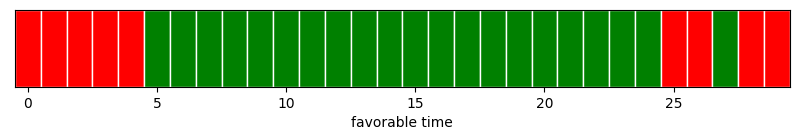

In [9]:
policy = policy_wec_full
filename=None
fig, ax =plt.subplots(1,figsize=(10,1))
ax.get_yaxis().set_visible(False)
ax.set_xlim([0,30])
ax.set_xticks(np.arange(0,30,5)+0.5)
ax.set_xticklabels(np.arange(0,30,5))
ax.set_xlabel('favorable time')
for x in range(30):
    if policy[0,x] == 0:
        rect = Rectangle((x, 0), 1, 1, facecolor='red', edgecolor='white')
        ax.add_patch(rect)
    else:
        rect = Rectangle((x, 0), 1, 1, facecolor='green', edgecolor='white')
        ax.add_patch(rect)
if filename is not None:
    plt.savefig(filename,dpi=600, bbox_inches='tight')
plt.show()

# Fish farm thermal delousing

In [10]:
policy_delousing_full,_,_ = MDPsolver2(elaps, 30, 30, n = 3, t_aux = 0, c_down = -0.8, c_fail = -1)

Solution
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0]
 [0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1]
 [0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 

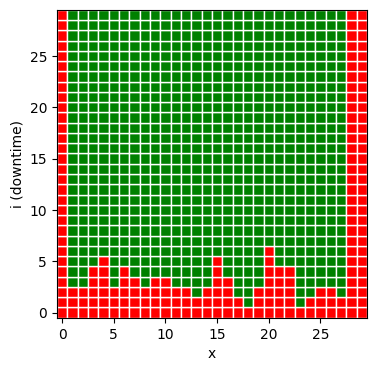

In [11]:
plotter2(policy_delousing_full,(30,30))

# Simulation

In [12]:
from scipy.stats import poisson, expon

In [13]:
# Thermal delousing issue modeling by poisson point process
# occurance rate: 4 event / year = 4 event * (365 days/year * 4 time points / day)^-1= 4 event /365/4 times points  
# 6 hourly 14600 time points
lbd_delousing = 1/365
num_event_delousing = poisson.rvs(lbd_delousing*len(df_metocean))
w_delousing = expon.rvs(scale = 1 / lbd_delousing, size=num_event_delousing)
delousing = np.cumsum(w_delousing,dtype=int).tolist()
delousing = np.array([x for x in delousing if x <= 14000])

In [29]:
# WEC failure issue modeling by poisson point process
# occurance rate: 1 event / year = 1 event * (365 days/year * 4 time points / day)^-1= 1 event /365/4 times points 
# 6 hourly 14600 time points
lbd_wec = 1/365/4
num_event_wec = poisson.rvs(lbd_wec*len(df_metocean))
w_wec = expon.rvs(scale = 1 / lbd_wec, size=num_event_wec)
wec_fail = np.cumsum(w_wec,dtype=int).tolist()
wec_fail = np.array([x for x in wec_fail if x <= 14000])

In [34]:
wec_fail = np.load('wecfail.npy')

# Policy-based

In [35]:
delousing_issue_on = False
delousing_issue_number = 0
delousing_working = 0
delousing_cost_down = lambda i: -0.8*np.exp(0.1*i)
delousing_cost_fail = -1
delousing_cost_accumulated_MDP = 0
delousing_worktime = 3
delousing_pass = 0

wec_issue_on = False
wec_issue_number = 0
wec_working = 0
wec_cost_down = -2
wec_cost_fail = -1
wec_cost_accumulated_MDP = 0
wec_worktime = 3
wec_pass = 0

verbose_delousing = False
verbose_wec = False

for i in range(len(df_metocean)):
    
    policy_delousing = policy_delousing_full
    policy_wec = policy_wec_full
    
    if not delousing_issue_on and (i == delousing[delousing_issue_number]):
        delousing_issue_on = True
        delousing_downtime = 0
        if verbose_delousing:
            print(f'Step {i}: Delousing needed {delousing_issue_number}')
    
    if delousing_issue_on:
        if delousing_pass == 0:
            if (delousing_working == 0) and (policy_delousing[min(delousing_downtime,30),min(ElapsedFavorableTime[i],30)].item() == 1):
                # "Go"
                if verbose_delousing:
                    print(f'Step {i}: Delousing Go | state ({delousing_downtime},{ElapsedFavorableTime[i]})')
                delousing_working += 1
            elif (delousing_working == 0) and (policy_delousing[min(delousing_downtime,30),min(ElapsedFavorableTime[i],30)].item() == 0):
                # "Stay"
                delousing_cost_accumulated_MDP += delousing_cost_down(min(delousing_downtime,30))
                delousing_downtime += 1
            elif (delousing_working > 0) and (delousing_working < delousing_worktime) and (ElapsedFavorableTime[i] > 0):
                # "Go" contd.
                if verbose_delousing:
                    print(f'Step {i}: Delousing Contd | working {delousing_working}')
                delousing_working += 1
            elif (delousing_working == delousing_worktime):
                # "Go" completed
                if verbose_delousing:
                    print(f'Step {i}: Delousing Issue Resolved {delousing_cost_accumulated_MDP}')
                delousing_working = 0
                if len(np.where(delousing > i)[0]) == 0:
                    delousing_issue_number = 0
                else:
                    delousing_issue_number = np.where(delousing > i)[0][0]
                delousing_issue_on = False
            elif ElapsedFavorableTime[i] == 0:
                # "Go" failed
                delousing_pass = delousing_worktime - delousing_working -1
                delousing_working = 0
                delousing_cost_accumulated_MDP += delousing_cost_fail
                for _ in range(delousing_worktime):
                    delousing_cost_accumulated_MDP += delousing_cost_down(min(delousing_downtime,30))
                    delousing_downtime += 1
                delousing_downtime += 1
                if verbose_delousing:
                    print(f'Step {i}: Delousing failed')
        else:
            delousing_pass -= 1
    
    if not wec_issue_on and (i == wec_fail[wec_issue_number]):
        wec_issue_on = True
        if verbose_wec:
            print(f'Step {i}: WEC Failed {wec_issue_number}')
                
    if wec_issue_on:
        if wec_pass == 0:
            if (wec_working == 0) and (policy_wec[:,min(ElapsedFavorableTime[i],30)].item() == 1):
                # "Go"
                if verbose_wec:
                    print(f'Step {i}: WEC O&M Go')
                wec_working += 1
            elif (wec_working == 0) and (policy_wec[:,min(ElapsedFavorableTime[i],30)].item() == 0):
                # "Stay"
                wec_cost_accumulated_MDP += wec_cost_down
            elif (wec_working > 0) and (wec_working < wec_worktime) and (ElapsedFavorableTime[i] > 0):
                # "Go" contd.
                wec_working += 1
            elif (wec_working == wec_worktime):
                # "Go" completed
                if verbose_wec:
                    print(f'Step {i}: WEC Issue Resolved {wec_cost_accumulated_MDP}')
                wec_working = 0
                if len(np.where(wec_fail > i)[0]) == 0:
                    wec_issue_number = 0
                else:
                    wec_issue_number = np.where(wec_fail > i)[0][0]
                wec_issue_on = False
            elif ElapsedFavorableTime[i] == 0:
                # "Go" failed
                wec_pass = wec_worktime - wec_working -1
                wec_working = 0
                wec_cost_accumulated_MDP += wec_worktime*wec_cost_down + wec_cost_fail
        else:
            wec_pass -= 1

print("{:.2E}".format(Decimal(delousing_cost_accumulated_MDP)))
print(wec_cost_accumulated_MDP)

-6.26E+3
-292


# Forecasting-based

In [36]:
delousing_issue_on = False
delousing_issue_number = 0
delousing_working = 0
delousing_cost_down = lambda i: -0.8*np.exp(0.1*i)
delousing_cost_fail = -1
delousing_cost_accumulated = 0
delousing_worktime = 3
delousing_pass = 0

wec_issue_on = False
wec_issue_number = 0
wec_working = 0
wec_cost_down = -2
wec_cost_fail = -1
wec_cost_accumulated = 0
wec_worktime = 3
wec_pass = 0

verbose_delousing = False
verbose_wec = False

forecast_uncertainty = 0.0

for i in range(len(df_metocean)):

    policy_delousing = policy_delousing_full
    policy_wec = policy_wec_full

    if not delousing_issue_on and (i == delousing[delousing_issue_number]):
        delousing_issue_on = True
        delousing_downtime = 0
        if verbose_delousing:
            print(f'Step {i}: Delousing needed {delousing_issue_number}')

    if delousing_issue_on:
        if delousing_pass == 0:
            true_future_delousing = (ElapsedFavorableTime[i+delousing_worktime-1] == ElapsedFavorableTime[i]+delousing_worktime-1) and (ElapsedFavorableTime[i] > 0)
            uncertain_future_delousing = np.random.choice([true_future_delousing,not true_future_delousing],1,p=[1-forecast_uncertainty,forecast_uncertainty]).item()
            if (delousing_working == 0) and uncertain_future_delousing and (ElapsedFavorableTime[i] > 0):
                # "Go"
                if verbose_delousing:
                    print(f'Step {i}: Delousing Go | state ({delousing_downtime},{ElapsedFavorableTime[i]})')
                delousing_working += 1
            elif (delousing_working == 0) and not uncertain_future_delousing:
                # "Stay"
                delousing_cost_accumulated += delousing_cost_down(min(delousing_downtime,30))
                delousing_downtime += 1
            elif (delousing_working > 0) and (delousing_working < delousing_worktime) and (ElapsedFavorableTime[i] > 0):
                # "Go" contd.
                if verbose_delousing:
                    print(f'Step {i}: Delousing Contd | working {delousing_working}')
                delousing_working += 1
            elif (delousing_working == delousing_worktime):
                # "Go" completed
                if verbose_delousing:
                    print(f'Step {i}: Delousing Issue Resolved {delousing_cost_accumulated}')
                delousing_working = 0
                if len(np.where(delousing > i)[0]) == 0:
                    delousing_issue_number = 0
                else:
                    delousing_issue_number = np.where(delousing > i)[0][0]
                delousing_issue_on = False
            elif ElapsedFavorableTime[i] == 0:    
                # "Go" failed
                delousing_pass = delousing_worktime - delousing_working -1
                delousing_working = 0
                delousing_cost_accumulated += delousing_cost_fail
                for _ in range(delousing_worktime):
                    delousing_cost_accumulated += delousing_cost_down(min(delousing_downtime,30))
                    delousing_downtime += 1
                delousing_downtime += 1
                if verbose_delousing:
                    print(f'Step {i}: Delousing failed')
        else:
            delousing_pass -= 1

    if not wec_issue_on and (i == wec_fail[wec_issue_number]):
        wec_issue_on = True
        if verbose_wec:
            print(f'Step {i}: WEC Maintenance {wec_issue_number}')

    if wec_issue_on:
        if wec_pass == 0:
            true_future_wec = (ElapsedFavorableTime[i+wec_worktime-1] == ElapsedFavorableTime[i]+wec_worktime-1) and (ElapsedFavorableTime[i] > 0)
            uncertain_future_wec = np.random.choice([true_future_wec,not true_future_wec],1,p=[1-forecast_uncertainty,forecast_uncertainty]).item()
            if (wec_working == 0) and uncertain_future_wec and (ElapsedFavorableTime[i] > 0):
                # "Go"
                if verbose_wec:
                    print(f'Step {i}: WEC O&M Go {wec_cost_accumulated}')
                wec_working += 1
            elif (wec_working == 0) and not uncertain_future_wec:
                # "Stay"
                wec_cost_accumulated += wec_cost_down
            elif (wec_working > 0) and (wec_working < wec_worktime) and (ElapsedFavorableTime[i] > 0):
                # "Go" contd.
                wec_working += 1
            elif (wec_working == wec_worktime):
                # "Go" completed
                if verbose_wec:
                    print(f'Step {i}: WEC Issue Resolved {wec_cost_accumulated}')
                wec_working = 0
                if len(np.where(wec_fail > i)[0]) == 0:
                    wec_issue_number = 0
                else:
                    wec_issue_number = np.where(wec_fail > i)[0][0]
                wec_issue_on = False
            elif (ElapsedFavorableTime[i] == 0):
                # "Go" failed
                wec_pass = wec_worktime - wec_working -1
                wec_working = 0
                wec_cost_accumulated += wec_worktime*wec_cost_down + wec_cost_fail
                if verbose_wec:
                    print(f'Step {i}: Maintenance Failed {wec_cost_accumulated}')
        else:
            wec_pass -= 1

print("{:.2E}".format(Decimal(delousing_cost_accumulated)))
print(wec_cost_accumulated)           

-6.19E+3
-240


# Different error rates

In [32]:
delousing_cost_accumulated_array = np.zeros([100,6])
delousing_num = np.zeros([100,6])
wec_cost_accumulated_array = np.zeros([100,6])

for m in range(100):    
    for n, forecast_uncertainty in enumerate([0,0.1,0.2,0.3,0.4,0.5]):

        delousing_issue_on = False
        delousing_issue_number = 0
        delousing_working = 0
        delousing_cost_down = lambda i: -0.8*np.exp(0.1*i)
        delousing_cost_fail = -1
        delousing_cost_accumulated = 0
        delousing_worktime = 3
        delousing_pass = 0

        wec_issue_on = False
        wec_issue_number = 0
        wec_working = 0
        wec_cost_down = -2
        wec_cost_fail = -1
        wec_cost_accumulated = 0
        wec_worktime = 3
        wec_pass = 0

        for i in range(len(df_metocean)):

            policy_delousing = policy_delousing_full
            policy_wec = policy_wec_full
            
            if not delousing_issue_on and (i == delousing[delousing_issue_number]):
                delousing_issue_on = True
                delousing_downtime = 0

            if delousing_issue_on:
                if delousing_pass == 0:
                    true_future_delousing = (ElapsedFavorableTime[i+delousing_worktime-1] == ElapsedFavorableTime[i]+delousing_worktime-1) and (ElapsedFavorableTime[i] > 0)
                    uncertain_future_delousing = np.random.choice([true_future_delousing,not true_future_delousing],1,p=[1-forecast_uncertainty,forecast_uncertainty]).item()
                    if (delousing_working == 0) and uncertain_future_delousing and (ElapsedFavorableTime[i] > 0):
                        # "Go"
                        delousing_working += 1
                    elif (delousing_working == 0) and not uncertain_future_delousing:
                        # "Stay"
                        delousing_cost_accumulated += delousing_cost_down(min(delousing_downtime,30))
                        delousing_downtime += 1
                    elif (delousing_working > 0) and (delousing_working < delousing_worktime) and (ElapsedFavorableTime[i] > 0):
                        # "Go" contd.
                        delousing_working += 1
                    elif (delousing_working == delousing_worktime):
                        # "Go" completed
                        delousing_working = 0
                        if len(np.where(delousing > i)[0]) == 0:
                            delousing_issue_number = 0
                        else:
                            delousing_issue_number = np.where(delousing > i)[0][0]
                        delousing_issue_on = False
                    elif ElapsedFavorableTime[i] == 0:
                        # "Go" failed
                        delousing_pass = delousing_worktime - delousing_working -1
                        delousing_working = 0
                        delousing_cost_accumulated += delousing_cost_fail
                        for _ in range(delousing_worktime):
                            delousing_cost_accumulated += delousing_cost_down(min(delousing_downtime,30))
                            delousing_downtime += 1
                        delousing_downtime += 1
                else:
                    delousing_pass -= 1

            if not wec_issue_on and (i == wec_fail[wec_issue_number]):
                wec_issue_on = True

            if wec_issue_on:
                if wec_pass == 0:
                    true_future_wec = (ElapsedFavorableTime[i+wec_worktime-1] == ElapsedFavorableTime[i]+wec_worktime-1) and (ElapsedFavorableTime[i] > 0)
                    uncertain_future_wec = np.random.choice([true_future_wec,not true_future_wec],1,p=[1-forecast_uncertainty,forecast_uncertainty]).item()
                    if (wec_working == 0) and uncertain_future_wec and (ElapsedFavorableTime[i] > 0):
                        # "Go"
                        wec_working += 1
                    elif (wec_working == 0) and not uncertain_future_wec:
                        # "Stay"
                        wec_cost_accumulated += wec_cost_down
                    elif (wec_working > 0) and (wec_working < wec_worktime) and (ElapsedFavorableTime[i] > 0):
                        # "Go" contd.
                        wec_working += 1
                    elif (wec_working == wec_worktime):
                        # "Go" completed
                        wec_working = 0
                        if len(np.where(wec_fail > i)[0]) == 0:
                            wec_issue_number = 0
                        else:
                            wec_issue_number = np.where(wec_fail > i)[0][0]
                        wec_issue_on = False
                    elif ElapsedFavorableTime[i] == 0:
                        # "Go" failed
                        wec_pass = wec_worktime - wec_working -1
                        wec_working = 0
                        wec_cost_accumulated += wec_worktime*wec_cost_down + wec_cost_fail
                else:
                    wec_pass -= 1
    
        delousing_cost_accumulated_array[m,n] = delousing_cost_accumulated
        wec_cost_accumulated_array[m,n] = wec_cost_accumulated

In [39]:
np.save('delousing_cost_accumulated_array_tmp_save2',delousing_cost_accumulated_array)

In [14]:
delousing_cost_accumulated_array = np.load('delousing_cost_accumulated_array_tmp_save2.npy')
wec_cost_accumulated_array = np.load('wec_cost_accumulated_array_tmp_save.npy')

In [15]:
print(-delousing_cost_accumulated_array[0,0])
print(-wec_cost_accumulated_array[0,0])

6187.472023585577
240.0


In [ ]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,2,figsize=[12,4])
ax[0].vlines([0,0.1,0.2,0.3,0.4,0.5], np.min(-delousing_cost_accumulated_array,axis=0)/-delousing_cost_accumulated_array[0,0], np.max(-delousing_cost_accumulated_array,axis=0)/-delousing_cost_accumulated_array[0,0], color='k', linestyle='-', lw=1)
ax[0].axhline(-delousing_cost_accumulated_MDP/-delousing_cost_accumulated_array[0,0],xmax=1,color='k',ls='--',label='MDP-based')
ax[0].scatter([0,0.1,0.2,0.3,0.4,0.5], np.mean(-delousing_cost_accumulated_array,axis=0)/-delousing_cost_accumulated_array[0,0], color='k', marker='o', label='Forecast-based')
ax[0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax[0].set_xticklabels(['True','10%','20%','30%','40%','50%'])
ax[0].set_xlabel('Forecast error rate')
ax[0].set_ylabel('10-year cost for delousing\n(normalized relative to no-forecast-error-case)')
ax[0].annotate('Cost used in normalization = 6,187',(-0.01,2.15))
ax[0].set_ylim([0.93917,2.2775])

ax[1].axhline(-wec_cost_accumulated_MDP/-wec_cost_accumulated_array[0,0],xmax=1,color='k',ls='--',label='MDP-based')
ax[1].scatter([0,0.1,0.2,0.3,0.4,0.5], np.mean(-wec_cost_accumulated_array,axis=0)/-wec_cost_accumulated_array[0,0], color='k', marker='o', label='Forecast-based mean')
ax[1].vlines([0,0.1,0.2,0.3,0.4,0.5], np.min(-wec_cost_accumulated_array,axis=0)/-wec_cost_accumulated_array[0,0], np.max(-wec_cost_accumulated_array,axis=0)/-wec_cost_accumulated_array[0,0], color='k', linestyle='-', lw=1,label='min-max bounds')
ax[1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax[1].set_xticklabels(['True','10%','20%','30%','40%','50%'])
ax[1].set_xlabel('Forecast error rate')
ax[1].set_ylabel('10-year cost for WEC maintenance\n(normalized relative to no-forecast-error-case)')
ax[1].annotate('Cost used in normalization = 240',(-0.01,1.8))
ax[1].set_ylim([0.93917,2.2775])
ax[1].legend(loc=2)
plt.tight_layout()
plt.savefig('case3.jpg', dpi=300, bbox_inches='tight')
plt.show()

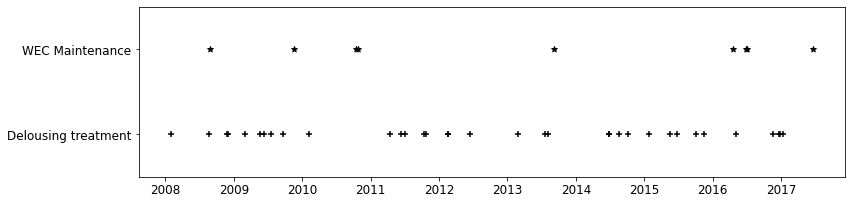

In [41]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax.scatter(delousing,np.full_like(delousing,0),marker='+',color='k')
ax.scatter(wec_fail,np.full_like(wec_fail,1),marker='*',color='k')
ax.set_xticks(np.arange(0,14600,1460))
ticklabels = [f'{i}' for i in range(2008,2018)]
ax.set_xticklabels(ticklabels)
ax.set_yticks((0,1))
ticklabels = ['Delousing treatment','WEC Maintenance']
ax.set_yticklabels(ticklabels)
ax.set_ylim([-0.5,1.5])
plt.tight_layout()
plt.savefig('two_activities.jpg', dpi=300, bbox_inches='tight')
plt.show()

# New Plot

In [42]:
for forecast_uncertainty in [0.0,0.1,0.5]:
    
    delousing_issue_on = False
    delousing_issue_number = 0
    delousing_working = 0
    delousing_cost_down = lambda i: -0.8*np.exp(0.1*i)
    delousing_cost_fail = -1
    delousing_cost_accumulated = 0
    delousing_worktime = 3
    delousing_pass = 0
    delousing_actions = []
    delousing_downtime_cost_log = []
    delousing_failure_cost_log = []

    wec_issue_on = False
    wec_issue_number = 0
    wec_working = 0
    wec_cost_down = -2
    wec_cost_fail = -1
    wec_cost_accumulated = 0
    wec_worktime = 3
    wec_pass = 0
    wec_actions = []
    wec_downtime_cost_log = []
    wec_failure_cost_log = []

    for i in range(len(df_metocean)):

        policy_delousing = policy_delousing_full
        policy_wec = policy_wec_full

        if not delousing_issue_on and (i == delousing[delousing_issue_number]):
            delousing_issue_on = True
            delousing_downtime = 0

        if delousing_issue_on:
            if delousing_pass == 0:
                true_future_delousing = (ElapsedFavorableTime[i+delousing_worktime-1] == ElapsedFavorableTime[i]+delousing_worktime-1) and (ElapsedFavorableTime[i] > 0)
                uncertain_future_delousing = np.random.choice([true_future_delousing,not true_future_delousing],1,p=[1-forecast_uncertainty,forecast_uncertainty]).item()
                if (delousing_working == 0) and uncertain_future_delousing:
                    delousing_actions.append([i,1])
                if (delousing_working == 0) and uncertain_future_delousing and (ElapsedFavorableTime[i] > 0):
                    # "Go"
                    delousing_working += 1
                elif (delousing_working == 0) and not uncertain_future_delousing:
                    # "Stay"
                    delousing_cost_accumulated += delousing_cost_down(min(delousing_downtime,30))
                    delousing_downtime_cost_log.append([i,delousing_cost_down(min(delousing_downtime,30))])
                    delousing_downtime += 1
                    delousing_actions.append([i,0])
                elif (delousing_working > 0) and (delousing_working < delousing_worktime) and (ElapsedFavorableTime[i] > 0):
                    # "Go" contd.
                    delousing_working += 1
                elif (delousing_working == delousing_worktime):
                    # "Go" completed
                    delousing_working = 0
                    if len(np.where(delousing > i)[0]) == 0:
                        delousing_issue_number = 0
                    else:
                        delousing_issue_number = np.where(delousing > i)[0][0]
                    delousing_issue_on = False
                elif ElapsedFavorableTime[i] == 0:    
                    # "Go" failed
                    delousing_pass = delousing_worktime - delousing_working -1
                    delousing_working = 0
                    delousing_cost_accumulated += delousing_cost_fail
                    tmp = 0
                    for _ in range(delousing_worktime):
                        delousing_cost_accumulated += delousing_cost_down(min(delousing_downtime,30))
                        tmp += delousing_cost_down(min(delousing_downtime,30))
                        delousing_downtime += 1
                    delousing_downtime_cost_log.append([i,tmp])
                    delousing_failure_cost_log.append([i,delousing_cost_fail])
                    delousing_downtime += 1
            else:
                delousing_pass -= 1

        if not wec_issue_on and (i == wec_fail[wec_issue_number]):
            wec_issue_on = True

        if wec_issue_on:
            if wec_pass == 0:
                true_future_wec = (ElapsedFavorableTime[i+wec_worktime-1] == ElapsedFavorableTime[i]+wec_worktime-1) and (ElapsedFavorableTime[i] > 0)
                uncertain_future_wec = np.random.choice([true_future_wec,not true_future_wec],1,p=[1-forecast_uncertainty,forecast_uncertainty]).item()
                if (wec_working == 0) and uncertain_future_wec:
                    wec_actions.append([i,1])
                if (wec_working == 0) and uncertain_future_wec and (ElapsedFavorableTime[i] > 0):
                    # "Go"
                    wec_working += 1
                elif (wec_working == 0) and not uncertain_future_wec:
                    # "Stay"
                    wec_cost_accumulated += wec_cost_down
                    wec_downtime_cost_log.append([i,wec_cost_down])
                    wec_actions.append([i,0])
                elif (wec_working > 0) and (wec_working < wec_worktime) and (ElapsedFavorableTime[i] > 0):
                    # "Go" contd.
                    wec_working += 1
                elif (wec_working == wec_worktime):
                    # "Go" completed
                    wec_working = 0
                    if len(np.where(wec_fail > i)[0]) == 0:
                        wec_issue_number = 0
                    else:
                        wec_issue_number = np.where(wec_fail > i)[0][0]
                    wec_issue_on = False
                elif (ElapsedFavorableTime[i] == 0):
                    # "Go" failed
                    wec_pass = wec_worktime - wec_working -1
                    wec_working = 0
                    wec_cost_accumulated += wec_worktime*wec_cost_down + wec_cost_fail
                    wec_downtime_cost_log.append([i,wec_worktime*wec_cost_down])
                    wec_failure_cost_log.append([i,wec_cost_fail])
            else:
                wec_pass -= 1  
                
    if forecast_uncertainty == 0:
        delousing_actions_true = np.array(delousing_actions)
        wec_actions_true = np.array(wec_actions)
        delousing_downtime_cost_true = np.array(delousing_downtime_cost_log)
        delousing_failure_cost_true = np.array(delousing_failure_cost_log)
        wec_downtime_cost_true = np.array(wec_downtime_cost_log)
        wec_failure_cost_true = np.array(wec_failure_cost_log)
    elif forecast_uncertainty == 0.1:
        delousing_actions_uncertain1 = np.array(delousing_actions)
        wec_actions_uncertain1 = np.array(wec_actions)
        delousing_downtime_cost_uncertain1 = np.array(delousing_downtime_cost_log)
        delousing_failure_cost_uncertain1 = np.array(delousing_failure_cost_log)
        wec_downtime_cost_uncertain1 = np.array(wec_downtime_cost_log)
        wec_failure_cost_uncertain1 = np.array(wec_failure_cost_log)
    elif forecast_uncertainty == 0.5:
        delousing_actions_uncertain5 = np.array(delousing_actions)
        wec_actions_uncertain5 = np.array(wec_actions)
        delousing_downtime_cost_uncertain5 = np.array(delousing_downtime_cost_log)
        delousing_failure_cost_uncertain5 = np.array(delousing_failure_cost_log)
        wec_downtime_cost_uncertain5 = np.array(wec_downtime_cost_log)
        wec_failure_cost_uncertain5 = np.array(wec_failure_cost_log)

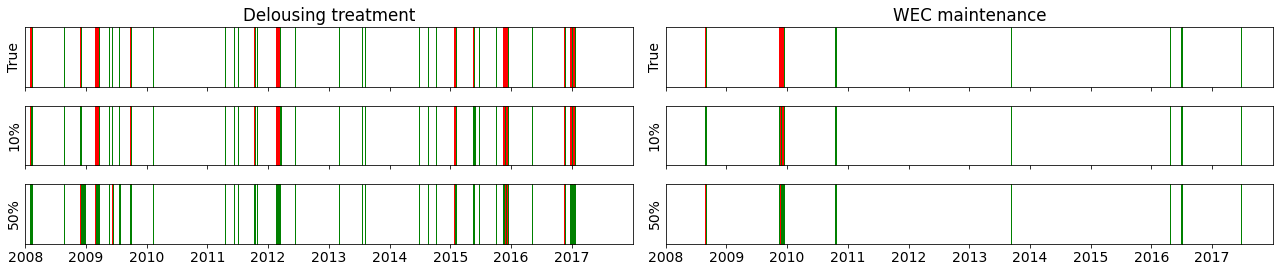

In [45]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3,2, figsize=(18,4))
for i in range(delousing_actions_true.shape[0]):
    if delousing_actions_true[i,1] == 0:
        ax[0,0].fill_between([delousing_actions_true[i,0],delousing_actions_true[i,0]+1],0,1,color='r')
    else:
        ax[0,0].fill_between([delousing_actions_true[i,0],delousing_actions_true[i,0]+1],0,1,color='g')
ax[0,0].set_title('Delousing treatment')
ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel('True')

for i in range(delousing_actions_uncertain1.shape[0]):
    if delousing_actions_uncertain1[i,1] == 0:
        ax[1,0].fill_between([delousing_actions_uncertain1[i,0],delousing_actions_uncertain1[i,0]+1],0,1,color='r')
    else:
        ax[1,0].fill_between([delousing_actions_uncertain1[i,0],delousing_actions_uncertain1[i,0]+1],0,1,color='g')
ax[1,0].set_xticklabels([])
ax[1,0].set_ylabel('10%')

for i in range(delousing_actions_uncertain5.shape[0]):
    if delousing_actions_uncertain5[i,1] == 0:
        ax[2,0].fill_between([delousing_actions_uncertain5[i,0],delousing_actions_uncertain5[i,0]+1],0,1,color='r')
    else:
        ax[2,0].fill_between([delousing_actions_uncertain5[i,0],delousing_actions_uncertain5[i,0]+1],0,1,color='g')
ax[2,0].set_ylabel('50%')

for i in range(wec_actions_true.shape[0]):
    if wec_actions_true[i,1] == 0:
        ax[0,1].fill_between([wec_actions_true[i,0],wec_actions_true[i,0]+1],0,1,color='r')
    else:
        ax[0,1].fill_between([wec_actions_true[i,0],wec_actions_true[i,0]+1],0,1,color='g')
ax[0,1].set_title('WEC maintenance')
ax[0,1].set_xticklabels([])
ax[0,1].set_ylabel('True')

for i in range(wec_actions_uncertain1.shape[0]):
    if wec_actions_uncertain1[i,1] == 0:
        ax[1,1].fill_between([wec_actions_uncertain1[i,0],wec_actions_uncertain1[i,0]+1],0,1,color='r')
    else:
        ax[1,1].fill_between([wec_actions_uncertain1[i,0],wec_actions_uncertain1[i,0]+1],0,1,color='g')
ax[1,1].set_xticklabels([])
ax[1,1].set_ylabel('10%')

for i in range(wec_actions_uncertain5.shape[0]):
    if wec_actions_uncertain5[i,1] == 0:
        ax[2,1].fill_between([wec_actions_uncertain5[i,0],wec_actions_uncertain5[i,0]+1],0,1,color='r')
    else:
        ax[2,1].fill_between([wec_actions_uncertain5[i,0],wec_actions_uncertain5[i,0]+1],0,1,color='g')
ax[2,1].set_ylabel('50%')

for axis in ax.ravel():
    axis.set_xticks(np.arange(0,14600,1460))
    axis.set_yticks([])
    axis.set_ylim([0,1])
    axis.set_xlim([0,14600])
    
ticklabels = [f'{i}' for i in range(2008,2018)]
ax[2,0].set_xticklabels(ticklabels)
ax[2,1].set_xticklabels(ticklabels)
plt.tight_layout()
plt.savefig('strips1', dpi=300, bbox_inches='tight')
plt.show()

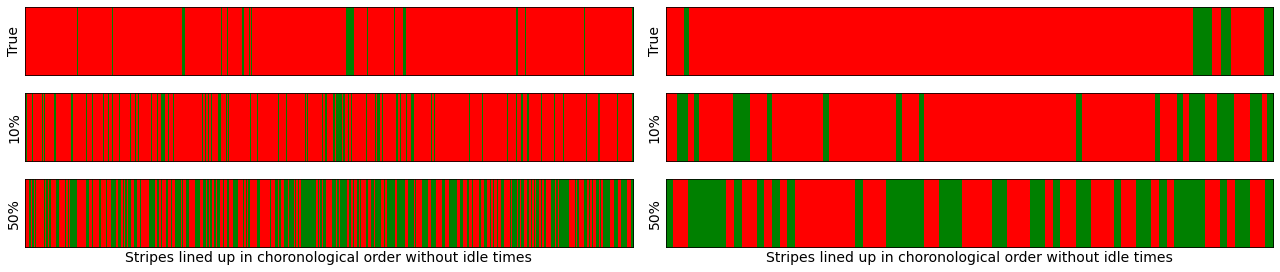

In [46]:
fig, ax = plt.subplots(3,2, figsize=(18,4))
count = 0
for i in range(delousing_actions_true.shape[0]):
    if delousing_actions_true[i,1] == 0:
        ax[0,0].fill_between([count,count+1],0,1,color='r')
        count += 1
    elif delousing_actions_true[i,1] == 1:
        ax[0,0].fill_between([count,count+1],0,1,color='g')
        count += 1
#ax[0,0].set_title('Delousing treatment')
ax[0,0].set_xticks([])
ax[0,0].set_xticklabels([])
ax[0,0].set_xlim([0,count])
ax[0,0].set_ylabel('True')

count = 0
for i in range(delousing_actions_uncertain1.shape[0]):
    if delousing_actions_uncertain1[i,1] == 0:
        ax[1,0].fill_between([count,count+1],0,1,color='r')
        count += 1
    elif delousing_actions_uncertain1[i,1] == 1:
        ax[1,0].fill_between([count,count+1],0,1,color='g')
        count += 1
ax[1,0].set_xticks([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xlim([0,count])
ax[1,0].set_ylabel('10%')

count = 0
for i in range(delousing_actions_uncertain5.shape[0]):
    if delousing_actions_uncertain5[i,1] == 0:
        ax[2,0].fill_between([count,count+1],0,1,color='r')
        count += 1
    elif delousing_actions_uncertain5[i,1] == 1:
        ax[2,0].fill_between([count,count+1],0,1,color='g')
        count += 1
ax[2,0].set_xticks([])
ax[2,0].set_xticklabels([])
ax[2,0].set_xlim([0,count])
ax[2,0].set_ylabel('50%')
ax[2,0].set_xlabel('Stripes lined up in choronological order without idle times')

count = 0
for i in range(wec_actions_true.shape[0]):
    if wec_actions_true[i,1] == 0:
        ax[0,1].fill_between([count,count+1],0,1,color='r')
        count += 1
    else:
        ax[0,1].fill_between([count,count+1],0,1,color='g')
        count += 1
#ax[0,1].set_title('WEC maintenance')
ax[0,1].set_xticks([])
ax[0,1].set_xticklabels([])
ax[0,1].set_xlim([0,count])
ax[0,1].set_ylabel('True')

count = 0
for i in range(wec_actions_uncertain1.shape[0]):
    if wec_actions_uncertain1[i,1] == 0:
        ax[1,1].fill_between([count,count+1],0,1,color='r')
        count += 1
    else:
        ax[1,1].fill_between([count,count+1],0,1,color='g')
        count += 1
ax[1,1].set_xticks([])
ax[1,1].set_xticklabels([])
ax[1,1].set_xlim([0,count])
ax[1,1].set_ylabel('10%')

count = 0
for i in range(wec_actions_uncertain5.shape[0]):
    if wec_actions_uncertain5[i,1] == 0:
        ax[2,1].fill_between([count,count+1],0,1,color='r')
        count += 1
    else:
        ax[2,1].fill_between([count,count+1],0,1,color='g')
        count += 1
ax[2,1].set_xticks([])
ax[2,1].set_xticklabels([])
ax[2,1].set_xlim([0,count])
ax[2,1].set_ylabel('50%')
ax[2,1].set_xlabel('Stripes lined up in choronological order without idle times')

for axis in ax.ravel():
    axis.set_yticks([])
    axis.set_ylim([0,1])
plt.tight_layout()
plt.savefig('strips2', dpi=300, bbox_inches='tight')
plt.show()